Работа № 2
Построив фазовую траекторию, можно (нужно) сделать оценку энтропии Колмогорова-Синая:
1. разбиения фазового пространства можно организовать с помощью алгоритма иерархической кластеризации.
2. варьируя дистанцию\размер кластеров можно получить множество (по счастью, конечное) разбиений, для которых оценить вероятности состояний и, следовательно, энтропии.
3. в качестве верхней границы (оценки KS-энтропии) системы выбрать наибольшее из рассчитанного
4. сделать выводы о связи энтропии со свойствами системы, а заодно о том, какое разбиение соответствует максимальному значению.

In [ ]:
!pip install giotto-tda

In [14]:
from gtda.time_series import embedding, TakensEmbedding
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import entropy

### Временной ряд с явными периодами

<Axes: title={'center': 'Daily min temperature'}, xlabel='date'>

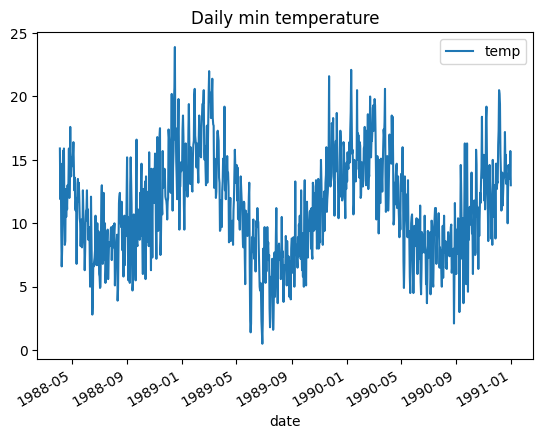

In [7]:
min_temp = pd.read_csv('data/daily-min-temperatures.csv')
min_temp = min_temp[-1000:]
min_temp.date = pd.to_datetime(min_temp.date)
min_temp = min_temp.set_index('date')
min_temp.plot(title="Daily min temperature")

### Хаотичный ряд

<Axes: title={'center': 'BTCUSDT 1m close price'}, xlabel='time'>

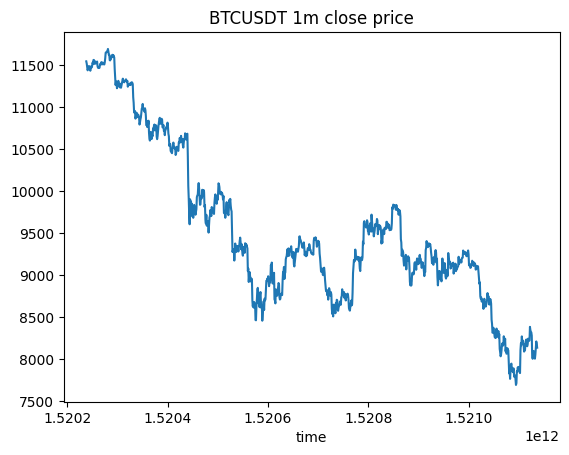

In [8]:
close_price = pd.read_csv('data/cryptoPrices15_wNB.csv')
close_price = close_price[['time','BTCUSDT']]
close_price = close_price[-1000:]
close_price= close_price.set_index('time')
close_price['BTCUSDT'].plot(title='BTCUSDT 1m close price')

### Трехмерный график фазового пространства(полученный в прошлой лабораторной работе) для хаотичного временного ряда


In [9]:
optimal_time_delay, optimal_embedding_dimension = embedding.takens_embedding_optimal_parameters(
    min_temp['temp'],
    150,
    15,
    stride=2,
)
print(f"Optimal embedding dimension is {optimal_embedding_dimension} and time delay is {optimal_time_delay}")

Optimal embedding dimension is 6 and time delay is 17


In [11]:
phase_space = TakensEmbedding(optimal_time_delay, optimal_embedding_dimension).fit_transform(min_temp['temp'].values.reshape(1, -1))[0]
tsne_results = TSNE(n_components=2, perplexity=30, n_iter=300).fit_transform(phase_space)

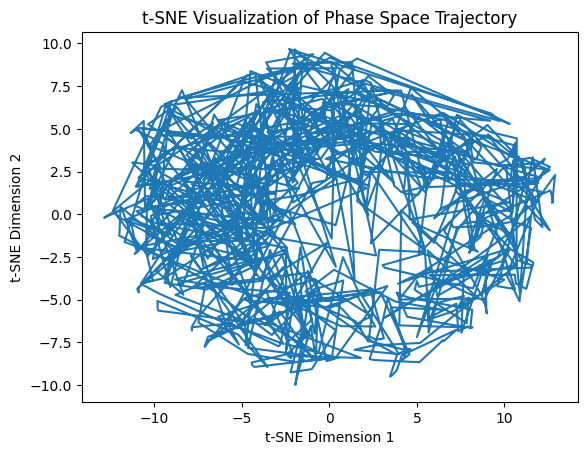

In [12]:
# Изображение фазовой траектории системы
plt.plot(tsne_results[:, 0], tsne_results[:, 1])
plt.title('t-SNE Visualization of Phase Space Trajectory')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

### Приступаем кластеризации


In [19]:
ac = AgglomerativeClustering(n_clusters=3, metric='euclidean')
ac.fit(tsne_results)

AgglomerativeClustering(metric='euclidean', n_clusters=3)

In [20]:
clustered_tsne_results = pd.concat([pd.DataFrame(tsne_results, columns=['x', 'y']), pd.DataFrame(ac.labels_.reshape(-1, 1), columns=['cluster'])], axis=1)

In [21]:
clustered_tsne_results

,x,y,cluster
0,1.736836,-4.726339,1
1,0.779071,-2.516646,1
2,-0.627787,-8.113007,0
3,-4.202746,-6.099201,0
4,-6.898519,-7.397337,0
...,...,...,...
910,3.698052,1.671805,2
911,4.114668,1.297687,2
912,5.264256,1.556528,2
913,3.609363,5.591707,2


In [25]:
cols=['x', 'y']
plot_2d = px.scatter(clustered_tsne_results, x="x", y="y",color='cluster')
plot_2d.show()

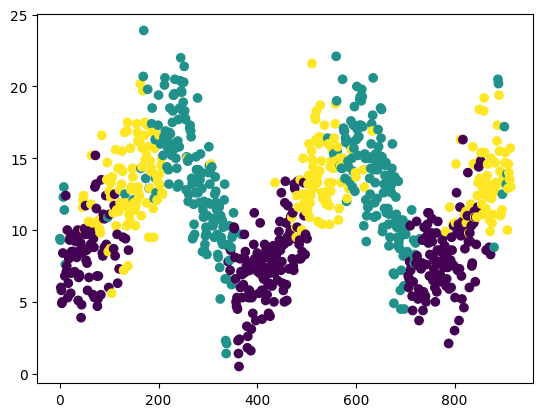

In [27]:
plt.scatter(x=clustered_tsne_results.index, y=min_temp[85:],c=clustered_tsne_results.cluster)
plt.show()

### Приступаем к оценке

In [41]:
probs = []
for cluster in clustered_tsne_results.cluster.unique():
    temp, _ = np.histogram(min_temp[85:].values[clustered_tsne_results.cluster == cluster], density=True, bins=len(min_temp[85:].values))
    probs.append(entropy(temp, base=2))

In [42]:
probs,max(probs)

([6.792021726993461, 6.335376358811598, 6.233387481196879], 6.792021726993461)

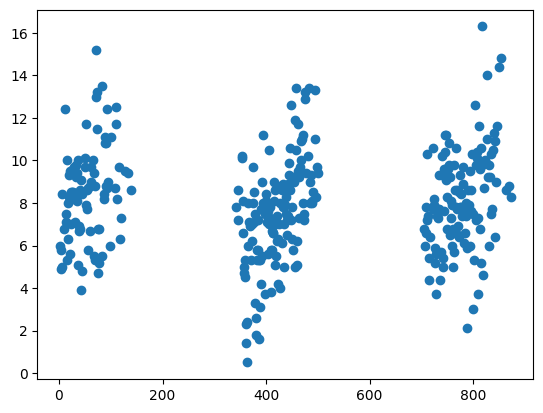

In [44]:
plt.scatter(x=clustered_tsne_results[clustered_tsne_results.cluster==0].index, y=min_temp[85:].values[clustered_tsne_results.cluster==0])
plt.show()